# Starbucks Sentiment Analysis 2018
An analysis of online comments at http://reddit.com. 




In [2]:
### Import Python Libraries
import numpy as np
import pandas as pd
import datetime

#Graphing Libraries
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

### Connect to Google Cloud Platform

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

key_location =  '/Users/steve/Documents/Programming/Keys/Google/Starbucks-Sentiment-e50e32624349.json'
credentials = service_account.Credentials.from_service_account_file(key_location)


project_id = 'starbucks-sentiment'
client = bigquery.Client(credentials=credentials,project=project_id)



### Pulls discussion threads that have a mention of Starbucks

In [4]:


sql = """with base_query as
(select *
  FROM
  (select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_01`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_02`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_03`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_04`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_05`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_06`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_07`
    union all
    select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_08`
    union all
select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_09`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_10`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_11`
  union all
  select subreddit,created_utc,parent_id,score,body,controversiality FROM `fh-bigquery.reddit_comments.2019_12`
  )
)
Select * from base_query
WHERE
   score > 1 AND body LIKE '%Starbucks%'
   and length(body) > 20
"""


#Flag to pull data from a local file rather than Bigquery

pull_data = False

if pull_data:
    print('Pull data from online')
    query_job = client.query(sql)
    df = query_job.result().to_dataframe()     
    df.drop(['parent_id','score','controversiality'],axis=1,inplace=True)
    df['created_utc'] = df['created_utc'].apply(lambda dt:datetime.datetime.utcfromtimestamp(dt))

else:
    print('Pull data from local file.')
    df = pd.read_pickle('Starbucks_Comments_2017_2018.pickle')
    print('df shape',df.shape)
    df2 = pd.read_pickle('Starbucks_Comments_2019.pickle')
    print('df2 shape',df2.shape)
    df.reset_index(drop=True,inplace=True)
    df2.reset_index(drop=True,inplace=True)
    
    frames = [df,df2]
    df = pd.concat(frames)
    print('combined',df.shape)
    
#Create an index
#We are keepting created_utc column for graphing
df.set_index('created_utc',inplace=True,drop=False)
#df.set_index('created_utc',inplace=True,drop=False)
df.head()

Pull data from local file.
df shape (236051, 3)
df2 shape (147288, 3)
combined (383339, 3)


,subreddit,created_utc,body
created_utc,,,
2018-12-28 00:17:21,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...
2018-12-06 00:32:31,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?
2018-12-04 01:26:05,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec..."
2018-12-30 01:26:05,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...
2018-12-03 01:21:10,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar..."


## Natural Language Processing

### Sentiment Example

In [38]:
sentences = ["Starbucks has the best customer service.",  # positive sentence example
             "I hate the long lines at Starbucks.",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "I went to Starbucks to get a coffee.",]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs['compound'])))

Starbucks has the best customer service.------------------------- 0.6369
I hate the long lines at Starbucks.------------------------------ -0.5719
I went to Starbucks to get a coffee.----------------------------- 0.0


### Sentiment function
- Split comments into sentences
- Calculate sentiment values
- Label sentiment value Positive, Negative, or Neutral

In [5]:
#VADER

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    def parse_sentences(text):
        blob = TextBlob(text)
        blob = blob.lower()
        return [sentence for sentence in blob.sentences]

    def polarities(sentences):
        sentence_polarities = []
        for sent in sentences:
            vs = analyzer.polarity_scores(sent)
            sentence_polarities.append (vs['compound'])
        return sentence_polarities
    def sentiment_label(polarities):
        #print('Polarities',polarities)
        return list(map(vader_polarity_label, polarities))
    
    return sentiment_label(polarities(parse_sentences(text)))




def vader_polarity_label(polarity_value):
    try:
        if polarity_value >= 0.05:
            return 'Positive'
        elif polarity_value <= -0.05:
            return 'Negative'
        elif polarity_value >-0.05 and polarity_value <0.05:
            return 'Neutral'
        else:
            return 'Unknown'
    except:
        pass

    
    

### Apply sentiment analysis function to each row in the Pandas dataframe

In [6]:
apply_sentiment = False

if apply_sentiment == True:
    df['sentiment'] = df['body'].apply(lambda x: vader_sentiment(x))
else:
    #df = pd.read_pickle('comments_with_sentiment.pickle')
    df = pd.read_pickle('comments_with_vader_sentiments.pickle')



### Sum the number of Positive, Negative, and Neutral comments in each post

In [7]:
def count_values(searched_list,target_text):
    return searched_list.count(target_text)


df['Positive'] = df['sentiment'].apply(lambda x: count_values(x,'Positive'))
df['Negative'] =df['sentiment'].apply(lambda x: count_values(x,'Negative'))
df['Neutral'] =df['sentiment'].apply(lambda x: count_values(x,'Neutral'))
df.drop(['sentiment'],axis=1,inplace=True)
df.head()

,subreddit,created_utc,body,Positive,Negative,Neutral
created_utc,,,,,,
2018-12-28 00:17:21,Eve,2018-12-28 00:17:21,your writing style resembles a sixteen year ol...,0,0,1
2018-12-06 00:32:31,thatHappened,2018-12-06 00:32:31,Why is it always the Starbucks cashiers?,0,0,1
2018-12-04 01:26:05,fatlogic,2018-12-04 01:26:05,"Starbucks Frappucinos don't count, either, bec...",1,0,0
2018-12-30 01:26:05,AskReddit,2018-12-30 01:26:05,My girlfriend was doing that when we started d...,2,2,3
2018-12-03 01:21:10,namenerds,2018-12-03 01:21:10,"Not Starbucks, but I used to have a couple bar...",2,1,1


Tally sentiments by date.

### Sum sentiment totals by date

In [9]:
df = df.resample('D').sum().reset_index()
df.head()

,created_utc,Positive,Negative,Neutral
0,2017-01-01,374,198,343
1,2017-01-02,455,318,488
2,2017-01-03,571,354,543
3,2017-01-04,562,269,527
4,2017-01-05,517,304,493


## Graph Results

## Important Dates

- April 12,2018 - Arrest occured 
- April 15,2018 - Starbucks CEO issued an apology
- May 29,2018   - All Starbucks stores closed for 1/2 day for sensitivity training


In [10]:
arrest_date = '2018-04-12'
arrest_date = datetime.datetime.strptime(arrest_date, '%Y-%m-%d')
apology_date = '2018-04-15'
apology_date = datetime.datetime.strptime(apology_date, '%Y-%m-%d')
close_date = '2018-05-29'
close_date = datetime.datetime.strptime(close_date, '%Y-%m-%d')

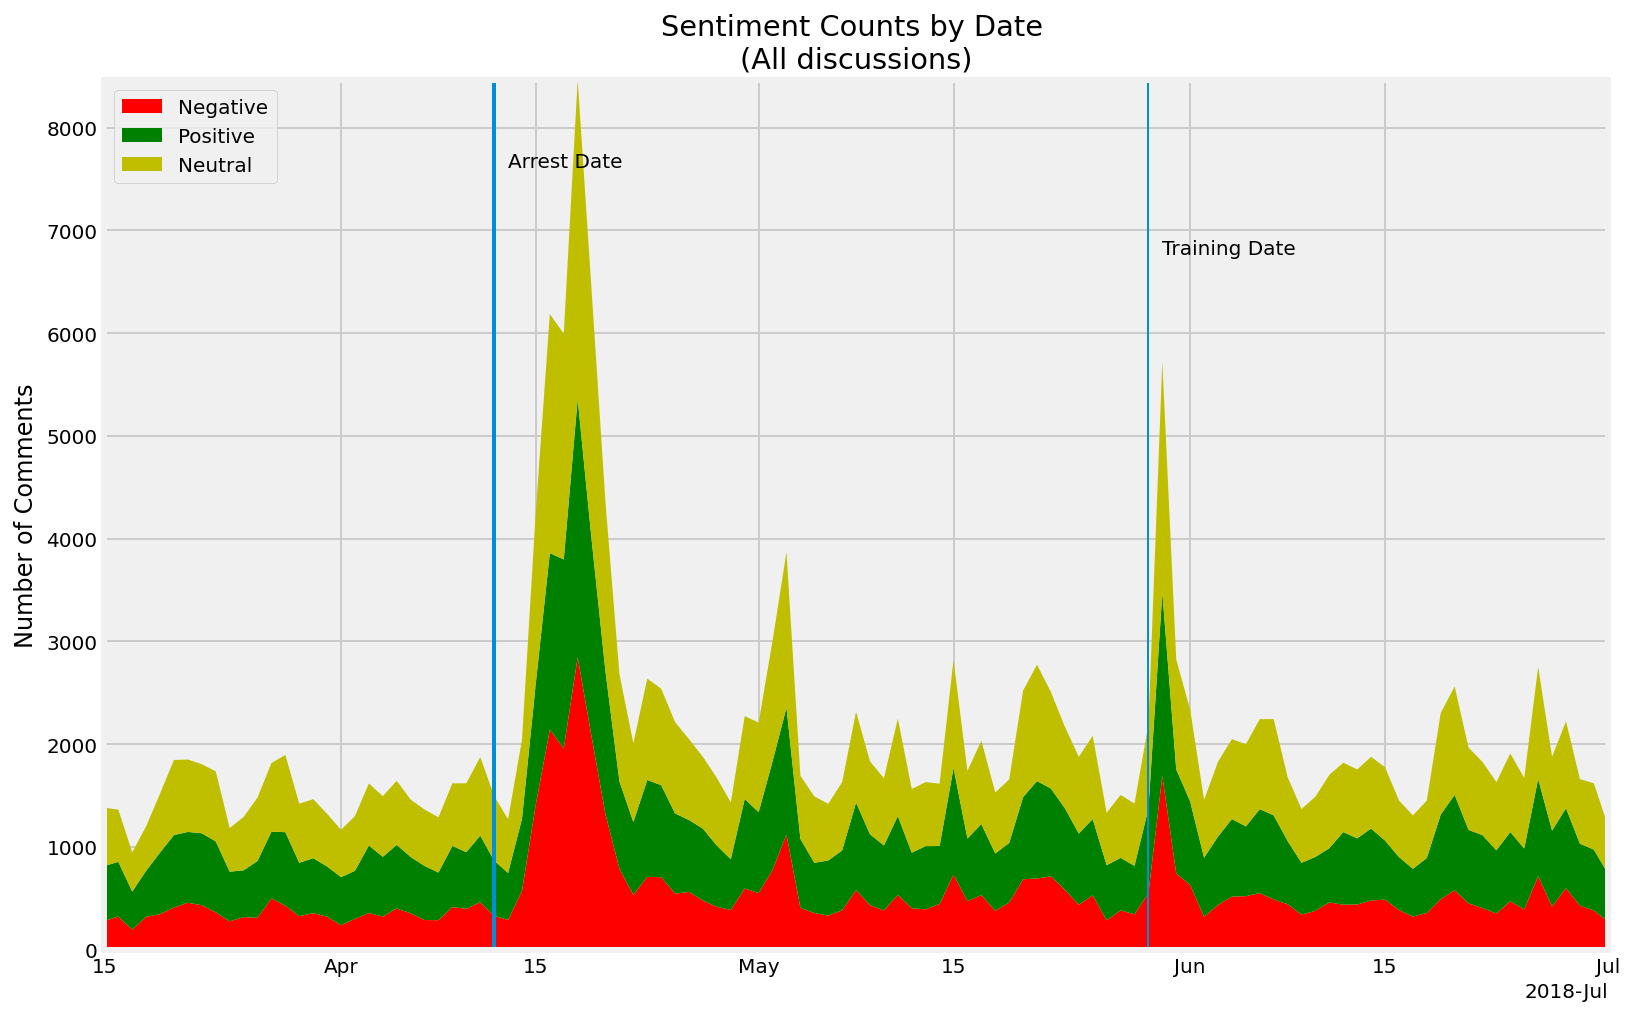

In [11]:

# All Discussion Threads
from matplotlib.dates import AutoDateLocator
from matplotlib.dates import ConciseDateFormatter

locator = AutoDateLocator()
formatter = ConciseDateFormatter(locator)


df_plot = df.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')


plt.figure(figsize=(12,8)) 
plt.stackplot(df_plot['created_utc'],df_plot["Negative"].rolling(window=1).mean(),  df_plot["Positive"].rolling(window=1).mean(),  df_plot["Neutral"].rolling(window=1).mean(), labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)
close_line = ax.axvline(close_date,linewidth=1)


ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.8, 'Training Date', transform=trans)
        
        
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Sentiment Counts by Date \n(All discussions)')
plt.savefig('starbucks_sentiments_by_date.svg', format='svg', dpi=1200)
plt.show()



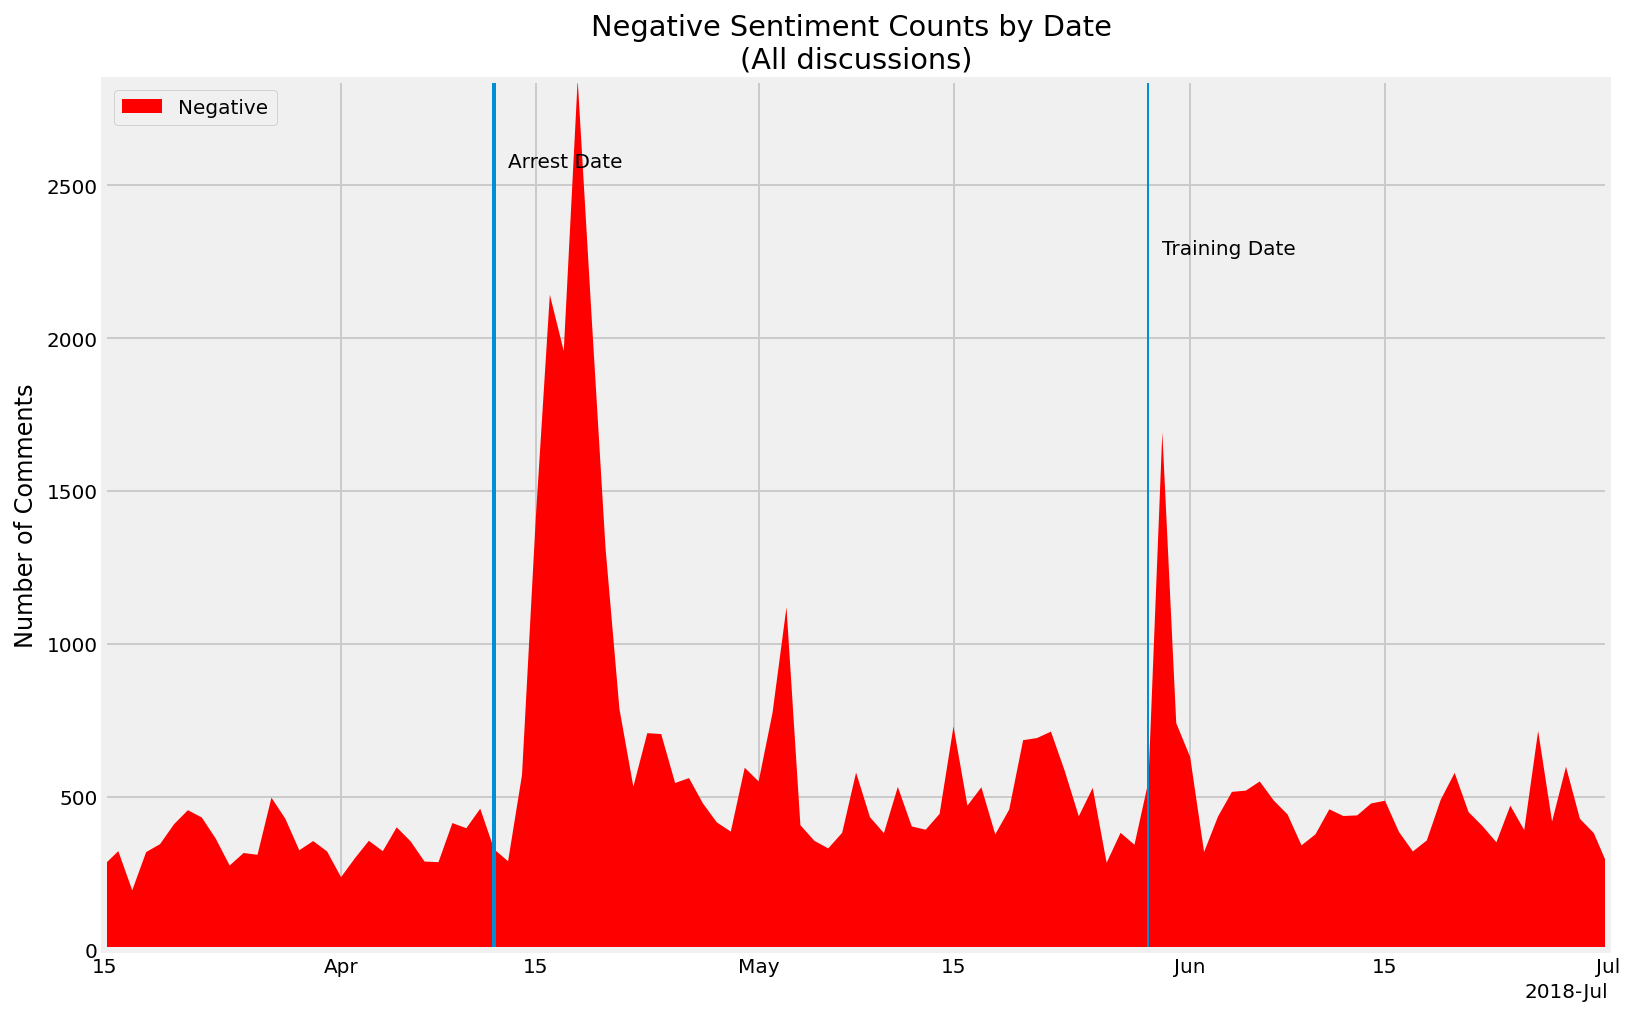

In [12]:
df_plot = df.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')

plt.figure(figsize=(12,8)) 
plt.stackplot(df_plot['created_utc'],df_plot["Negative"], labels=['Negative'],colors=['r'])
plt.legend(loc='upper left')



ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)
close_line = ax.axvline(close_date,linewidth=1)
ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.8, 'Training Date', transform=trans)
        
        
plt.ylabel('Number of Comments')
plt.margins(0,0)
plt.title('Negative Sentiment Counts by Date \n(All discussions)')
plt.savefig('Negative_Sentiments.svg', format='svg', dpi=1200)
plt.show()

## Detecting Changes in Brand Sentiment

### Highlight those days where comments exceed what is expected

Facebook Prophet is an easy to use forecasting library. The tool will make predictions from historical data.


In [26]:
from fbprophet import Prophet

df_fb = df.copy()
#df_fb['created_utc'] = pd.to_datetime(df_fb['created_utc'], format='%Y/%m/%d')
df_fb.drop(['Positive','Neutral'],axis=1,inplace=True)
df_fb.rename(columns={"created_utc":"ds","Negative":"y"},inplace=True)
df_fb.drop(df_fb.columns.difference(['ds','y']), 1, inplace=True)

#Exclude days from the model that are known to be unusual.
starbucks_changepoints = ['2018-04-16','2018-04-17','2018-04-18','2018-04-19','2018-05-30']

m = Prophet(changepoints=starbucks_changepoints)
m.fit(df_fb)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

forecast[['ds','yhat_lower','yhat_upper','additive_terms','yhat']]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat_lower,yhat_upper,additive_terms,yhat
0,2017-01-01,-11.177045,372.878465,-107.278893,185.322266
1,2017-01-02,59.520433,432.548902,-37.833682,255.060844
2,2017-01-03,77.784524,462.174919,-23.486703,269.701189
3,2017-01-04,77.241269,465.029449,-22.059800,271.421458
4,2017-01-05,61.916266,453.023257,-30.088298,263.686326
...,...,...,...,...,...
1090,2019-12-27,229.108762,602.158766,-49.459635,418.185132
1091,2019-12-28,159.709623,547.677350,-115.133186,352.570751
1092,2019-12-29,166.755447,539.771198,-102.829059,364.934047
1093,2019-12-30,234.722112,610.609328,-34.036474,433.785801


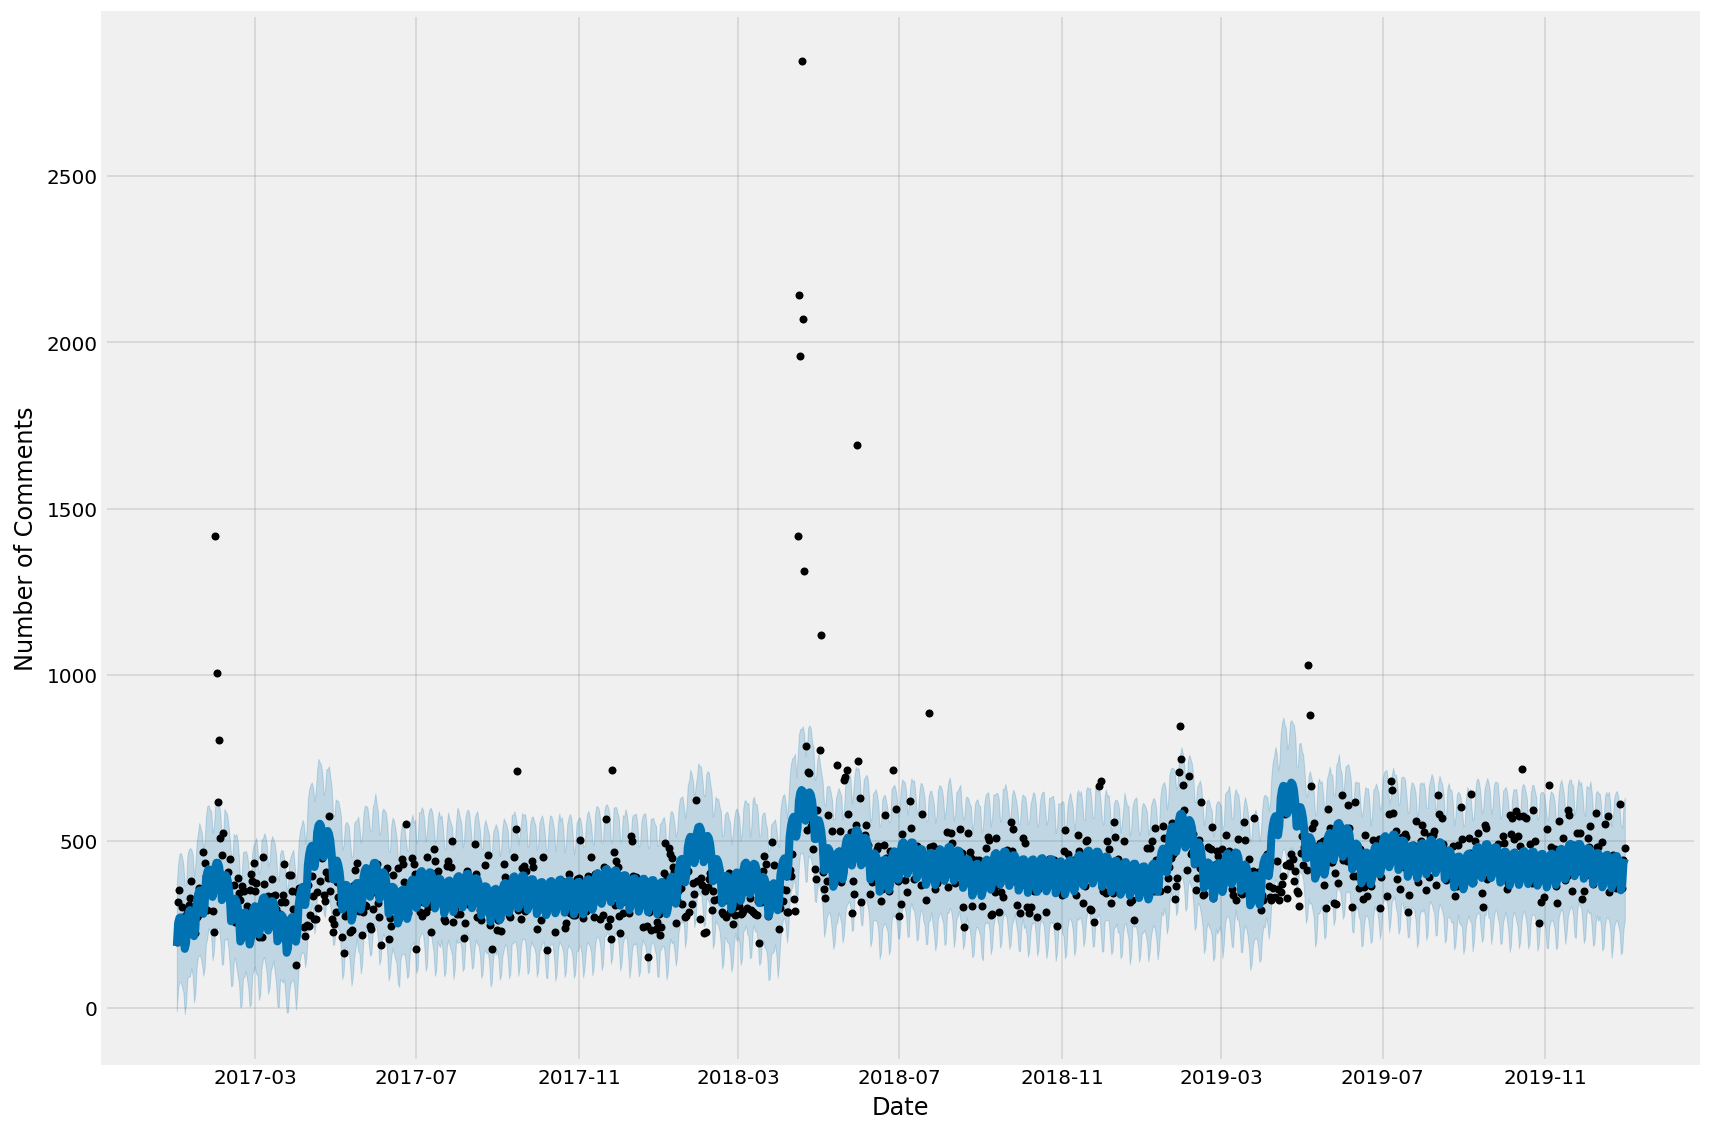

In [43]:
fig1 = m.plot(forecast,xlabel='Date',ylabel = 'Number of Comments',figsize=(12,8))

### Combine Actual and Forecasted Negative Comments

In [28]:
#Combine Actual and forecast
df_combined = df.merge(forecast,how='inner',left_on='created_utc',right_on='ds')
df_combined['pct_diff'] = (df_combined['Negative'] - df_combined['yhat'])/df_combined['Negative']

### Flag those days based on some business rule.

In [31]:

def percent_change(current_value,next_value):
    return((current_value-next_value)/current_value)

flag_percentage = .5


def flag_change(value,flag_percentage):
    if str.isnumeric(value) & value>=flag_percentage:
        return True
    

#df_combined['flag'] = np.where(df_combined['pct_difference']>=flag_percentage,True)
df_combined['Flagged'] = df_combined['pct_diff'].apply(lambda x: True if x >=flag_percentage else 'False')


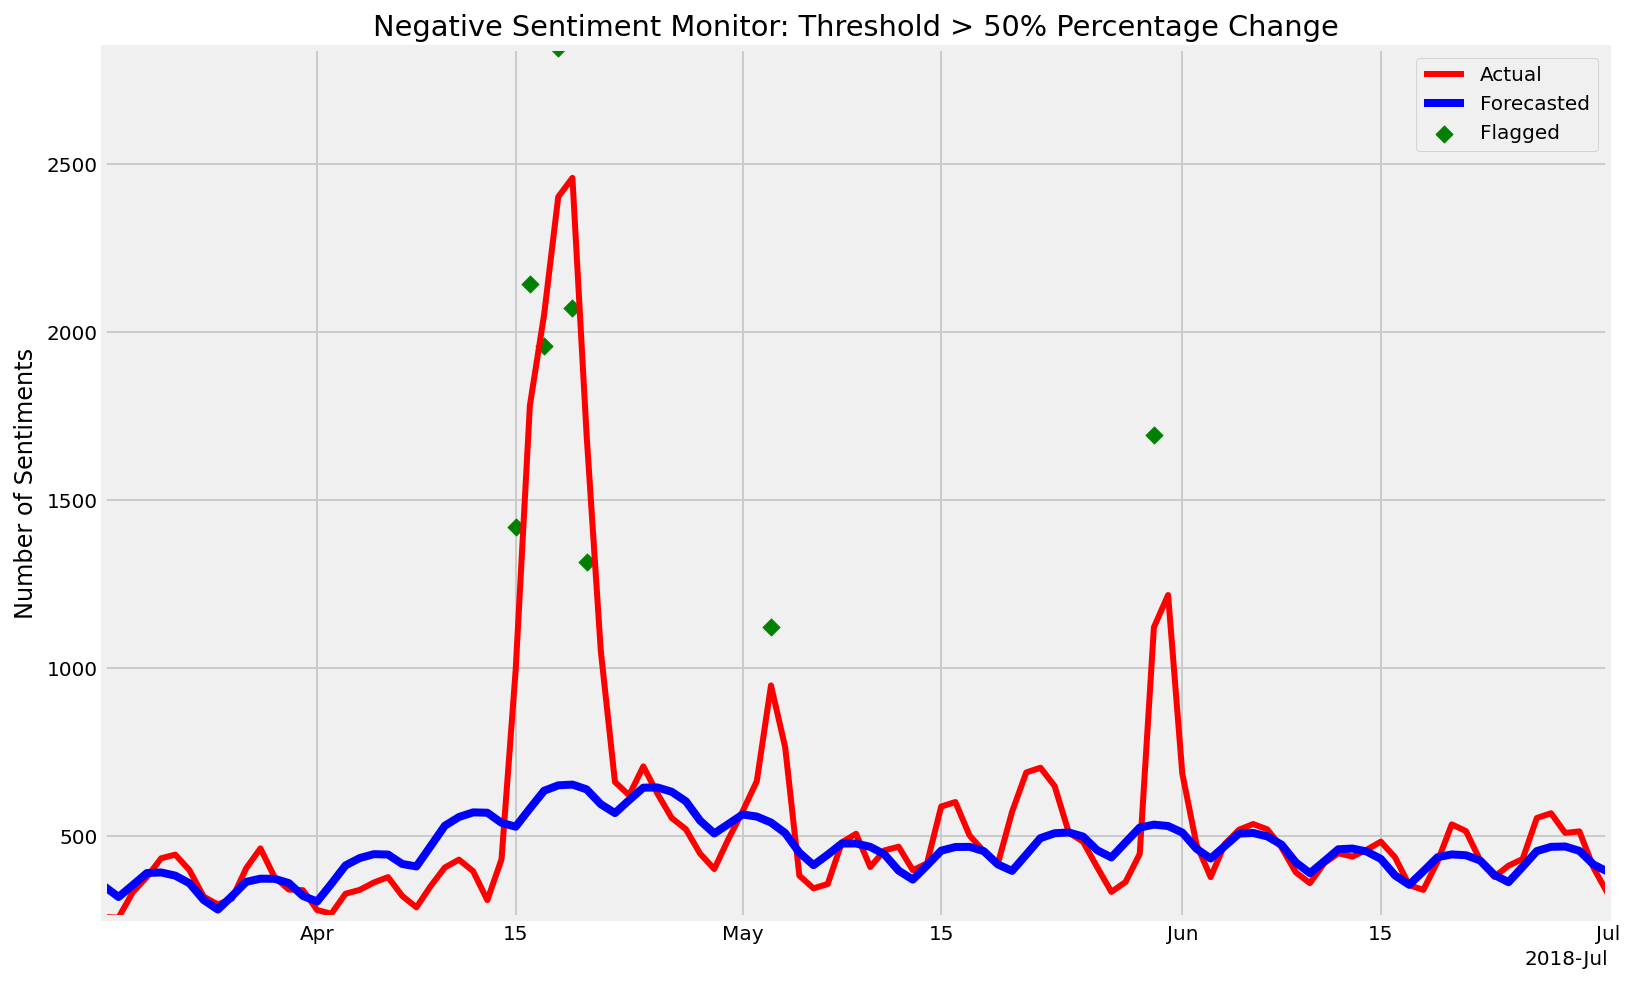

In [32]:
start_date = '03-15-2018'
end_date = '07-01-2018'


mask = (df_combined['created_utc'] > start_date) & (df_combined['created_utc'] <= end_date)
df_plot = df_combined.loc[mask].copy()

plt.figure(figsize=(12,8)) 
plt.plot(df_plot['created_utc'],df_plot["Negative"].rolling(window=2).mean(),color='r',linewidth=3,label='Actual')
plt.plot(df_plot['created_utc'],df_plot['yhat'].rolling(window=2).mean(),color='b',label='Forecasted')

df_flagged = df_plot[df_plot['Flagged']==True]



plt.scatter(df_flagged['created_utc'],df_flagged['Negative'],color='g',marker='D',label='Flagged')


ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)


# plt.plot(forecast['ds'],forecast['yhat'].rolling(window=7).mean(),linewidth=1)
 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)    
    
plt.ylabel('Number of Sentiments')
plt.margins(0,0)
plt.title('Negative Sentiment Monitor: Threshold > 50% Percentage Change')
plt.savefig('Reputation Monitoring.svg',format='svg', dpi=1200)
plt.show()


In [33]:
df_all = df.copy()
df_all['positive_perc'] = df_all['Positive'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])
df_all['neutral_perc'] = df_all['Neutral'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])
df_all['negative_perc'] = df_all['Negative'].divide(df_all['Positive'] + df_all['Neutral']+df_all['Negative'])

In [34]:
df_all.set_index('created_utc',inplace=True,drop=False)

## Plot Sentiment Percentages


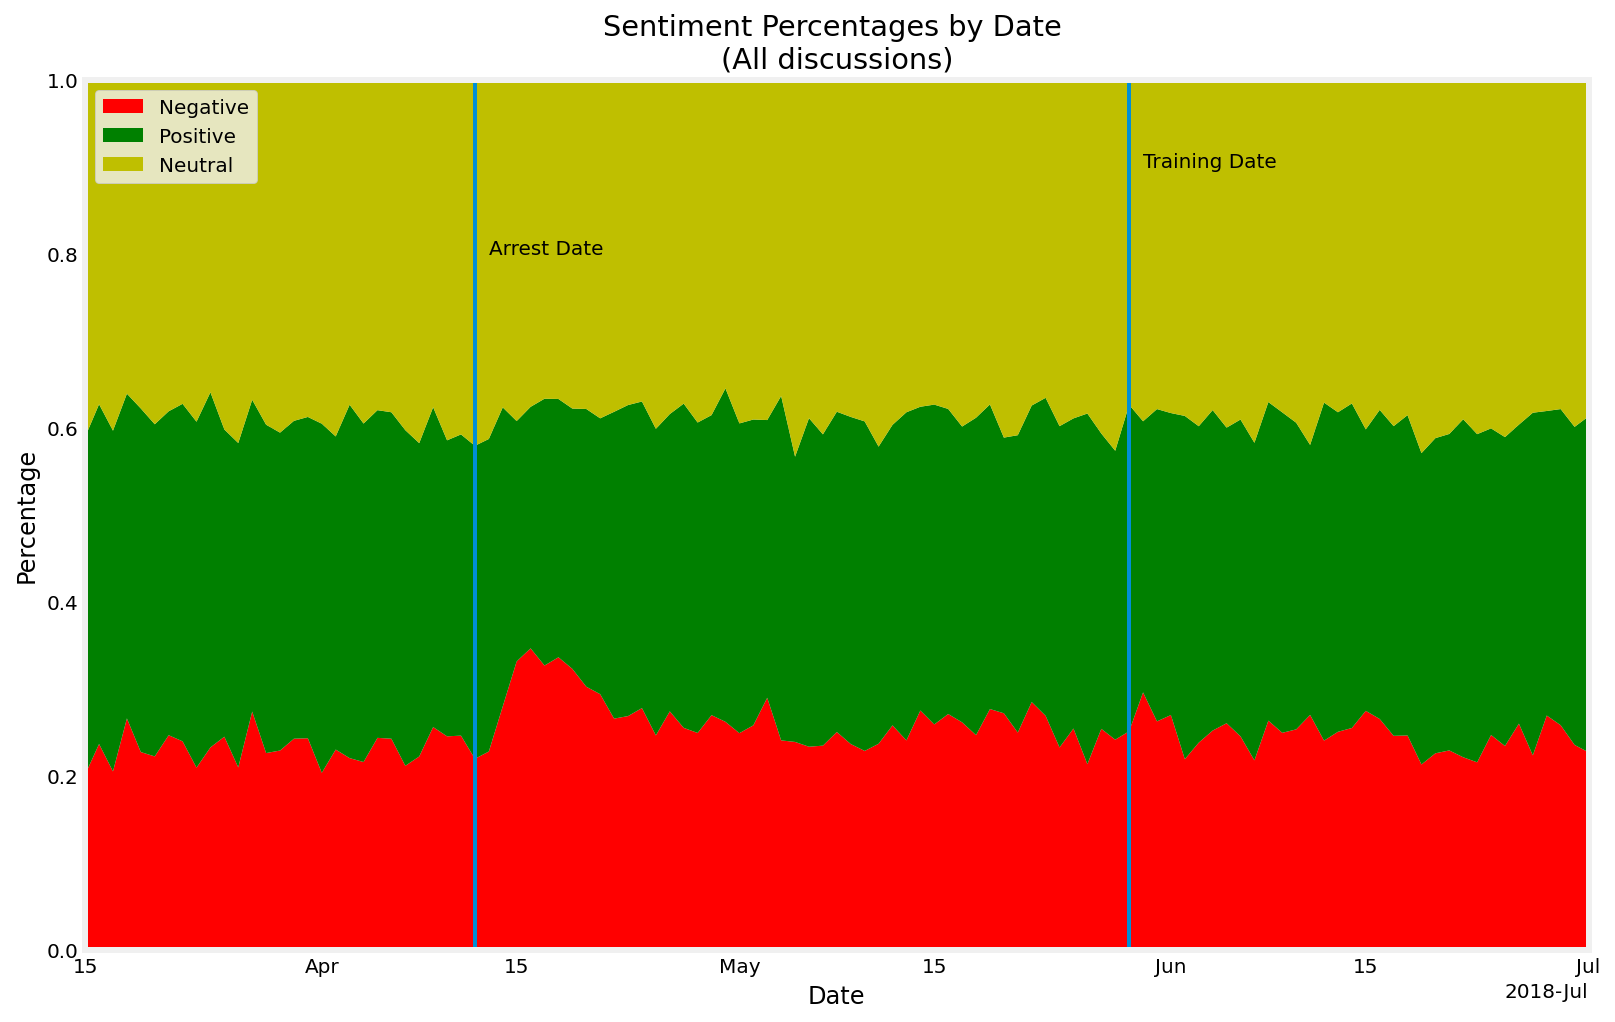

In [36]:
# Make the plot


df_all = df_all.query('created_utc >= "2018-03-15" & created_utc <= "2018-07-01" ')

plt.figure(figsize=(12,8)) 
plt.stackplot(df_all['created_utc'],  df_all['negative_perc'],  df_all['positive_perc'],  df_all['neutral_perc'], labels=['Negative','Positive','Neutral'],colors=['r','g','y'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date,linewidth=2)

ax.axvline(close_date,linewidth=2)

ax.text(arrest_date + datetime.timedelta(days=1)  ,.8, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Sentiment Percentages by Date \n(All discussions)')
plt.savefig('Sentiment_Percentages.svg', format='svg', dpi=1200)
plt.show();

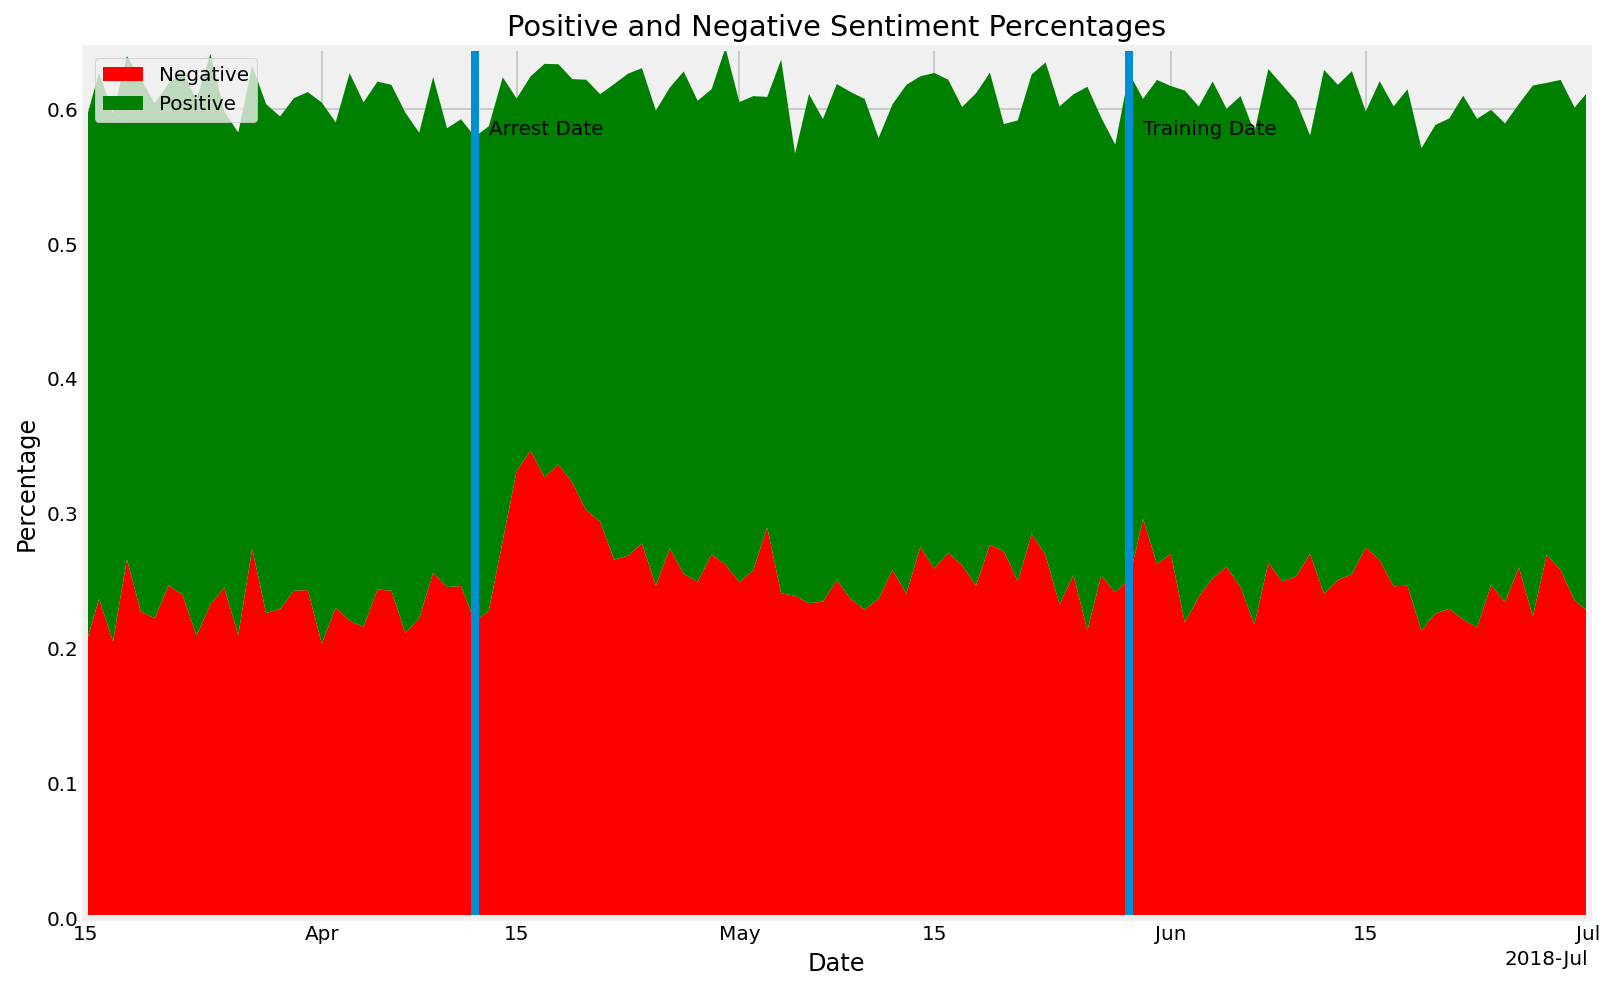

In [37]:

plt.figure(figsize=(12,8)) 
plt.stackplot(df_all['created_utc'],  df_all['negative_perc'],  df_all['positive_perc'] ,labels=['Negative','Positive'],colors=['r','g'])
plt.legend(loc='upper left')

ax = plt.gca()
trans = ax.get_xaxis_transform()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
arrest_line = ax.axvline(arrest_date) 
ax.axvline(close_date)

ax.text(arrest_date + datetime.timedelta(days=1)  ,.9, 'Arrest Date', transform=trans)
ax.text(close_date + datetime.timedelta(days=1)  ,.9, 'Training Date', transform=trans)
        
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.margins(0,0)
plt.title('Positive and Negative Sentiment Percentages')
plt.show();

# Observations


There was a spike of negative sentiment three days after the incident (April 12,2018) that dropped lower but not quite to the pre-incident levels. 

A second spike of negative sentiment occurred on May 29,2018 when Starbucks closed its stores for sensitivity training.

The ratio of positive sentiment to negative sentiment was stable throughout the year.

Mentions of Starbucks and the positive sentiment of the comments on website improved within 1 week.


# Conclusion

    


The incident that occurred during April 2018 had an observable impact on people's feelings about the company based on discussions on reddit.com. 


# Additional Information

https://www.inquirer.com/news/starbucks-incident-philadelphia-racial-bias-one-year-anniversary-stutter-dilworth-park-homeless-tables-20190412.html
    
    